In [4]:
import seaborn as sns
import tensorflow as tf
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import pickle
import os


class Config:
    MATCHER = ("^(.*)_(.*)_(.*)_(\d+)_(\d+)_(\d*\.?\d*)_(\d*\.?\d*)(_trial\d+)?")

    def __init__(self, filename):
        groups = self.matches(filename)
        self.strategy = groups[0]
        self.dataset = groups[1]
        self.network = groups[2]
        self.top_k = int(groups[3])
        self.pool_size = int(groups[4])
        self.lr = float(groups[5])
        self.decay = float(groups[6])
        self.trial = None
        if groups[7]:
            unparsed_trial = groups[7]
            self.trial = int(unparsed_trial.strip("_trial"))

    def matches(self, filename):
        import re
        return (re.match(Config.MATCHER, filename)).groups()
    

In [5]:
def plot_image_distributions(pickles_dir, plot_dir):
    for filename in os.listdir(pickles_dir):
        config = Config(filename)
        pickles_file = os.path.join(pickles_dir, filename)
        with open(pickles_file, 'rb') as handle:
            d = pickle.load(handle)
            n, bins, patches = plt.hist(d.values(),
                                        50,
                                        normed=0,
                                        facecolor='green',
                                        alpha=0.75)

            plt.xlim(0, max(d.values()) + 1)
            plt.xlabel("Num backprops")
            plt.ylabel("Num images")

            subplot_dir = os.path.join(plot_dir, "images_dist")
            if not os.path.isdir(subplot_dir):
                os.mkdir(subplot_dir)
            plot_file = os.path.join(subplot_dir, filename + ".pdf")
            plt.savefig(plot_file)
            plt.clf()


In [35]:
def plot_batch_statistics(pickles_dir, plot_dir, series_keys):
    stats_plot_dir = os.path.join(plot_dir, "batch_stats")
    if not os.path.isdir(stats_plot_dir):
        os.mkdir(stats_plot_dir)
    #stats_keys = ["average", "p25", "p50", "p75", "p90", "max", "min"]
    stats_keys = ["average", "p50"]
    for filename in os.listdir(pickles_dir):
        config = Config(filename)
        # Select what configs to graph
        if config.trial != 1 or config.top_k == config.pool_size:
            continue
        pickles_file = os.path.join(pickles_dir, filename)
        print(pickles_file)
        with open(pickles_file, 'rb') as handle:
            d = pickle.load(handle)
            for stat_key in stats_keys:
                # Plot one graph per batch stat
                for series_key in series_keys:
                    ys = []
                    for snapshot in d:
                        ys.append(snapshot[series_key][stat_key])
                    xs = range(len(ys))
                    plt.scatter(xs, ys, label = series_key, alpha=0.8, s=1)
                plt.legend()
                plt.xlabel("Pool ID")
                plt.ylabel("{}".format(stat_key))
                plot_file = os.path.join(stats_plot_dir, "{}_{}.png".format(filename,
                                                                            stat_key))
                plt.title("{} on {} {}/{}".format(config.network,
                                                  config.dataset,
                                                  config.top_k,
                                                  config.pool_size))
                plt.savefig(plot_file)
                plt.show()
                plt.clf()
                
            # Plot ratio of backprops
            ys = []
            for snapshot in d:
                num_backpropped = snapshot["num_backpropped"]
                num_skipped = snapshot["num_skipped"]
                if num_skipped + num_backpropped == 0:
                    continue
                y = float(num_backpropped) / (num_skipped + num_backpropped)
                ys.append(y)
            xs = range(len(ys))
            plt.legend()
            plt.xlabel("Pool ID")
            plt.ylabel("Ratio Backpropped")
            plot_file = os.path.join(stats_plot_dir, "{}_ratio_backpropped.png".format(filename))
            plt.title("{}, {} on {} {}/{}".format(config.strategy,
                                                  config.network,
                                                  config.dataset,
                                                  config.top_k,
                                                  config.pool_size))
            plt.savefig(plot_file)
            plt.show()
            plt.clf()
            


In [36]:
def plot_experiment(experiment_dir,
                    plot_dir,
                    smoothing=0,
                    stats_keys = ["chosen_losses", "pool_losses"]):
    pickles_dir = os.path.join(experiment_dir, "pickles")
    if os.path.isdir(pickles_dir):
        # image_id_hist_dir = os.path.join(pickles_dir, "image_id_hist")
        # if os.path.isdir(image_id_hist_dir):
        #    plot_image_distributions(image_id_hist_dir, plot_dir)
            
        batch_stats_dir = os.path.join(pickles_dir, "batch_stats")
        if os.path.isdir(batch_stats_dir):
            plot_batch_statistics(batch_stats_dir, plot_dir, stats_keys)
            

../data/output/cifar10/180924b/pickles/batch_stats/sampling_cifar10_mobilenet_0_32_0.001_0.0001_trial1_batch_stats.pickle


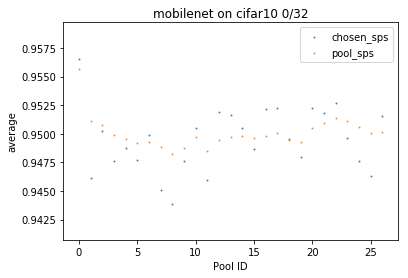

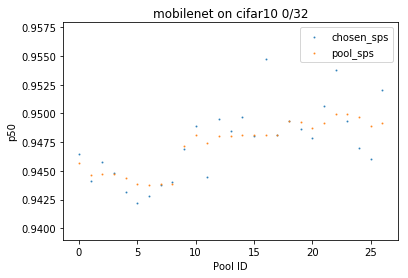

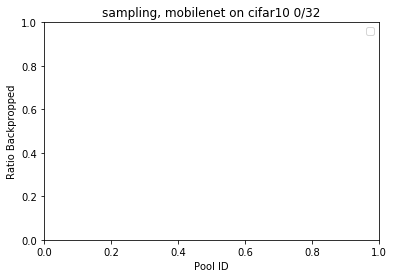

../data/output/cifar10/180924b/pickles/batch_stats/sampling_cifar10_resnet_0_32_0.001_0.0001_trial1_batch_stats.pickle


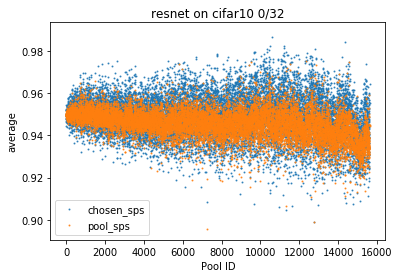

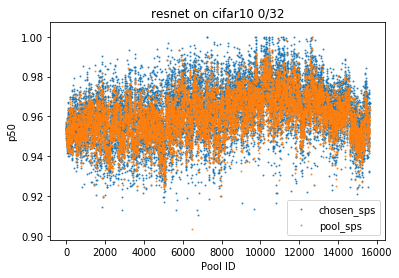

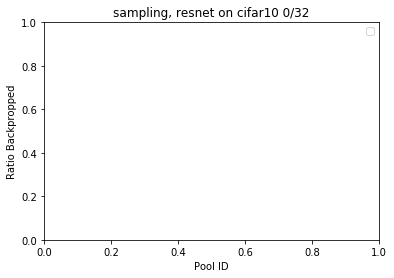

../data/output/cifar10/180924b/pickles/batch_stats/topk_cifar10_mobilenet_24_32_0.001_0.0001_trial1_batch_stats.pickle


In [ ]:
plot_home_dir = "../plots"

# MobileNet and ResNet with 250000 backprops
experiment_name = "180924b"
experiment_dir = "../data/output/cifar10/{}".format(experiment_name)
plot_dir = "{}/{}".format(plot_home_dir, experiment_name)
stats_keys = ["chosen_sps", "pool_sps"]
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)
plot_experiment(experiment_dir, plot_dir, 250, stats_keys=stats_keys)
